# Q3: Retrieval-Augmented Generation (RAG) over PDF

This section demonstrates a RAG chatbot over a PDF using open-source LLMs. Bonus features include history-aware responses, a knowledge graph, KV-cache, and agentic architecture.


In [1]:
!pip install python-dotenv pypdf langchain-community groq faiss-cpu networkx matplotlib

## 1. Set Up and Imports

We set up the environment and import all necessary libraries.


In [2]:
import os
from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from groq import Groq
import networkx as nx
import matplotlib.pyplot as plt
import re


## 2. API Key Setup

Seting  Groq API key

In [ ]:
os.environ["GROQ_API_KEY"] = "fill_your_key_here"

## 3. PDF Parsing and Chunking

Parsing the PDF and spliting it into semantic chunks for retrieval.

In [4]:
def parse_pdf_to_chunks(pdf_path, chunk_size=700, chunk_overlap=100):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text + "\n"
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_text(text)
    return chunks


### Vector Store Creation

I am using FAISS, a fast vector similarity search library, to build an index of the PDF chunks. Each chunk is embedded using a pre-trained sentence-transformer model. This allows us to efficiently retrieve the most semantically relevant sections of the document for any user query.


In [5]:
def build_vector_store(chunks):
    embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vector_store = FAISS.from_texts(chunks, embedding=embedder)
    return vector_store

### Retrieval Function

Given a user query, we retrieve the top-k most relevant chunks from the vector store using semantic similarity. This ensures that the LLM receives the most contextually appropriate information from the PDF for answer generation.


In [6]:
def retrieve_relevant_chunks(vector_store, query, k=5):
    docs_and_scores = vector_store.similarity_search_with_score(query, k=k)
    return [doc.page_content for doc, _ in docs_and_scores]

### Knowledge Graph Extraction and Visualization

We extract simple entity-relation triples from the PDF using regular expressions (e.g., "X is Y"). These are used to build a knowledge graph with NetworkX, which helps visualize relationships in the document.


In [7]:
import re
import networkx as nx
import matplotlib.pyplot as plt

def extract_entities_relations(text):
    pattern = r"(\w+) (is|has) (\w+)"
    return re.findall(pattern, text)

def build_knowledge_graph(chunks):
    G = nx.Graph()
    for chunk in chunks:
        for entity1, relation, entity2 in extract_entities_relations(chunk):
            G.add_edge(entity1, entity2, relation=relation)
    return G

def show_knowledge_graph(G):
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

### KV-Cache

To speed up repeated queries, we implement a simple key-value cache. If a prompt has already been answered, we return the cached response instead of querying the LLM again. This reduces latency and API usage.

In [8]:
response_cache = {}

def query_with_cache(prompt, client):
    if prompt in response_cache:
        return response_cache[prompt]
    answer = query_groq(prompt, client)
    response_cache[prompt] = answer
    return answer

In [9]:
class ChatMemory:
    def __init__(self):
        self.history = []
    def add(self, question, answer):
        self.history.append((question, answer))
    def get_history_str(self):
        return "\n".join([f"Q: {q}\nA: {a}" for q, a in self.history])

def build_prompt(context_chunks, question, memory):
    context_text = '\n'.join(context_chunks)
    history = memory.get_history_str()
    return f"""You are a helpful assistant. Use ONLY the following context and chat history to answer the question.
Chat history:
{history}

Context:
{context_text}

Question: {question}
Answer:"""


### History-Aware Prompt and Memory

We maintain a memory of previous questions and answers to provide the LLM with dialogue history. This enables the chatbot to generate more coherent and context-aware multi-turn responses.

In [10]:
class InformationExtractionAgent:
    def extract(self, text):
        entities = re.findall(r"\b[A-Z][a-z]*\b", text)
        return {"entities": entities}

class SynthesisAgent:
    def synthesize(self, extracted_info):
        return f"Key entities: {', '.join(extracted_info['entities'])}"

class QueryAgent:
    def answer(self, question, context, client):
        prompt = build_prompt(context, question, memory)
        return query_with_cache(prompt, client)

class Coordinator:
    def __init__(self, client):
        self.info_agent = InformationExtractionAgent()
        self.synth_agent = SynthesisAgent()
        self.query_agent = QueryAgent()
        self.client = client
    def handle(self, context_chunks, question):
        extracted = self.info_agent.extract(" ".join(context_chunks))
        summary = self.synth_agent.synthesize(extracted)
        full_context = context_chunks + [summary]
        answer = self.query_agent.answer(question, full_context, self.client)
        return {
            "extracted": extracted,
            "summary": summary,
            "answer": answer
        }


### Agentic Architecture

We modularize the system into agents:
- **InformationExtractionAgent:** Extracts entities from context.
- **SynthesisAgent:** Summarizes extracted entities.
- **QueryAgent:** Handles natural language questions using the RAG pipeline.
- **Coordinator:** Orchestrates the workflow between agents and composes the final answer.
This architecture makes the system extensible and easier to debug.


In [11]:
def query_groq(prompt, client, model="llama3-70b-8192"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.1,
        max_tokens=512
    )
    return response.choices[0].message.content.strip()


### Groq LLM Query Function

This function sends the constructed prompt to the Groq API (using Llama 3) and returns the generated answer. The LLM is instructed to use only the provided context and chat history for grounded, document-based responses.


Parsing PDF and building vector store...


<ipython-input-5-c2bc07f7ebff>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or data

Building knowledge graph...


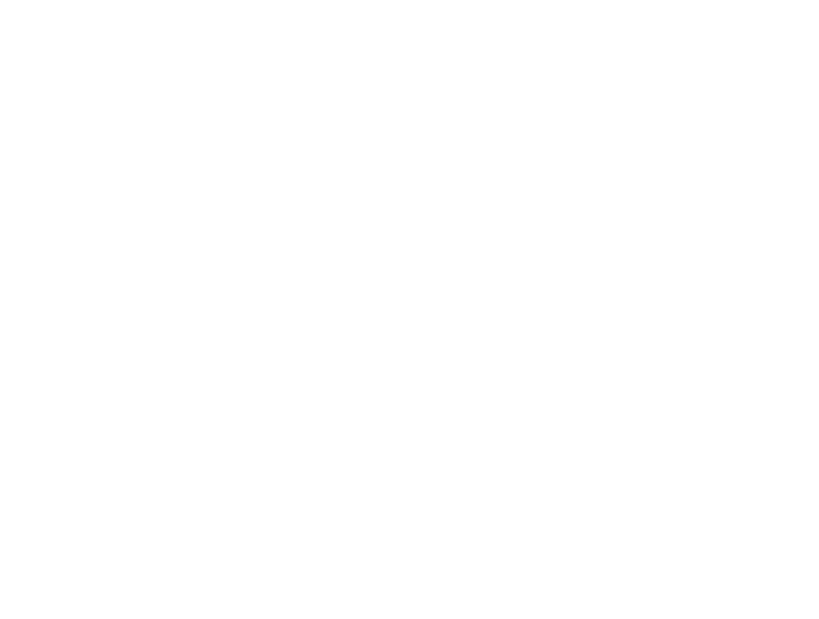

Ready! Ask questions about the PDF (type 'exit' to quit).

Your question: what is the pdf about

Answer: The PDF is about the AI Community Assignment 2025, which consists of Technical and Non-Technical problems.

Your question: what is the first question

Answer: The first question is Technical Problem 1, but the exact question is not specified in the chat history. However, based on the context, it can be inferred that the first question is related to creating a simple communication protocol between agents using JSON, designing a basic coordinator that manages the workflow between agents, and implementing error handling for when agents fail or provide incomplete information.

Your question: exit


In [12]:
def main():
    pdf_path = "/content/AICommunity_Assignment_25.pdf"  # Change if you want to upload another file
    print("Parsing PDF and building vector store...")
    chunks = parse_pdf_to_chunks(pdf_path)
    vector_store = build_vector_store(chunks)
    print("Building knowledge graph...")
    G = build_knowledge_graph(chunks)
    show_knowledge_graph(G)
    print("Ready! Ask questions about the PDF (type 'exit' to quit).")
    client = Groq(api_key=os.environ["GROQ_API_KEY"])
    global memory
    memory = ChatMemory()
    coordinator = Coordinator(client)
    while True:
        question = input("\nYour question: ")
        if question.lower() in ["exit", "quit"]:
            break
        context_chunks = retrieve_relevant_chunks(vector_store, question, k=5)
        result = coordinator.handle(context_chunks, question)
        answer = result["answer"]
        print(f"\nAnswer: {answer}")
        memory.add(question, answer)

if __name__ == "__main__":
    main()


### Main Chat Loop

This is the interactive interface for the RAG chatbot. It initializes all components, displays the knowledge graph, and allows the user to ask questions about the PDF. The system retrieves relevant context, processes it through the agentic pipeline, and generates grounded answers using the Groq LLM.
